In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipdb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import matplotlib.gridspec as gridspec
import pickle
from modelGPT.utils import eval_on_dataset
from modelGPT.model_gpt_predictor import ModelGPTPredictor

from tqdm import tqdm

from modelGPT.constants import DATASET_COL, MODELS, PARAMETERS, FEATURE_ORDER_DICT, ALL_FEATURES, GROUND_TRUTH_CSV, MODEL_NAME_COL


sns.set_palette('colorblind', n_colors=9)
linestyle = ['-','--','-.', ':']
#sns.set(font_scale=1.2)
plt.rcParams['font.size'] = 13

df = pd.read_csv(GROUND_TRUTH_CSV)
all_dataset = df.dataset.unique()
PRED_TARGET='acc1'


In [2]:
name_order = {'imagenet1k':'ImageNet','sun397':'SUN397', 'flowers':'flowers102', 'caltech101':'CalTech101',
              'pets':'Oxford Pets','cifar100':'CIFAR100', 
          'cars':'Stanford Cars','stl10':'stl10','voc2007':'VOC2007','resisc45':'resisc45',
              'eurosat':'euroSAT','fgvc_aircraft':'FGVC aircraft', 'gtsrb':'GTSRB',
          'kitti_closest_vehicle_distance':'KITTI','country211':'country211', 'dmlab':'DMLab', 'svhn':'SVHN','fer2013':'FER2013','diabetic_retinopathy':'Retinopathy',
          'clevr_closest_object_distance':'CLEVR-DISTANCE','clevr_count_all':'CLEVR-COUNT','mnist':'MNIST','dtd':'DTD', 'pcam':'Pcam', 'renderedsst2':'renderedsst2'
             }


In [3]:
dataset_rankings = {}

all_dataset = df.dataset.unique()
non_cls=['svhn','country211','mnist','clevr_closest_object_distance', 'clevr_count_all', 'eurosat', 'pcam',  'kitti_closest_vehicle_distance', 'fer2013', 'dtd', 'renderedsst2','diabetic_retinopathy','dmlab']
real_cls = [i for i in all_dataset if i not in non_cls and i != 'imagenet1k']
datasets = ['imagenet1k']+real_cls + non_cls

order_dict = {v: i for i, v in enumerate(datasets)}

df['dataset_order'] = pd.Categorical(df['dataset'], categories=order_dict.keys(), ordered=True).map(order_dict)

# Sort the DataFrame by the 'datasets' column
df = df.sort_values('dataset')
models=df.model.unique()

for dataset in datasets:
    df_dataset = df.loc[df.dataset==dataset][["model_fullname", "pretrained", PRED_TARGET,"dataset", "dataset_order"]]
    dataset_rankings[dataset] = df_dataset.sort_values(PRED_TARGET, ascending=False).reset_index()
    dataset_rankings[dataset]['rank']=dataset_rankings[dataset].index

    
len(all_dataset)

23

In [4]:
name_mapping = {
    'coca_ViT-B-32 laion2b_s13b_b90k': 'CoCa-ViT-B/32, L2b-c',
    'coca_ViT-B-32 mscoco_finetuned_laion2b_s13b_b90k': 'CoCa-ViT-B/32, L2b-c + coco',
    'coca_ViT-L-14 laion2b_s13b_b90k': 'CoCa-ViT-L/14, L2b-c',
    'coca_ViT-L-14 mscoco_finetuned_laion2b_s13b_b90k': 'CoCa-ViT-L/14, L2b-c + coco',
    'convnext_base laion400m_s13b_b51k': 'ConvNEXT-B, L400m-c',
    'convnext_base_w laion2b_s13b_b82k': 'ConvNEXT-BW, L2b-d',
    'convnext_base_w laion2b_s13b_b82k_augreg': 'ConvNEXT-BW, L2b-e',
    'convnext_base_w laion_aesthetic_s13b_b82k': 'ConvNEXT-BW, L2b-f',
    'convnext_base_w_320 laion_aesthetic_s13b_b82k': 'ConvNEXT-BW-320, L2b-f',
    'convnext_base_w_320 laion_aesthetic_s13b_b82k_augreg': 'ConvNEXT-B-BW-320, L2b-g',
    'convnext_large_d laion2b_s26b_b102k_augreg': 'ConvNEXT-LD, L2b-h',
    'convnext_large_d_320 laion2b_s29b_b131k_ft': 'ConvNEXT-LD-320, L2b-i',
    'convnext_large_d_320 laion2b_s29b_b131k_ft_soup': 'ConvNEXT-LD-320, L2b-j',
    'RN50 openai': 'RN50, WIT',
    'RN101 openai': 'RN101, WIT',
    'RN50x4 openai': 'RN50x4, WIT',
    'RN50x16 openai': 'RN50x16, WIT',
    'RN50x64 openai': 'RN50x64, WIT',
    'ViT-B-32 openai': 'ViT-B/32, WIT',
    'ViT-B-16 openai': 'ViT-B/16, WIT',
    'ViT-L-14 openai': 'ViT-L/14, WIT',
    'ViT-L-14-336 openai': 'ViT-L/14-336, WIT',
    'ViT-B-16 laion400m_e32': 'ViT-B/16, L400m-a',
    'ViT-B-16-plus-240 laion400m_e32': 'ViT-B/16-240, L400m-a',
    'ViT-B-32 laion2b_e16': 'ViT-B/32, L2b-c',
    'ViT-B-32 laion2b_s34b_b79k': 'ViT-B/32, L2b-b',
    'ViT-B-32 laion400m_e31': 'ViT-B/32, L400m-b',
    'ViT-B-32 laion400m_e32': 'ViT-B/32, L400m-a',
    'ViT-B-32-quickgelu laion400m_e32': 'ViT-B/32, L400m-a',
    'ViT-H-14 laion2b_s32b_b79k': 'ViT-H/14, L2b-b',
    'ViT-L-14 laion2b_s32b_b82k': 'ViT-L/14, L2b-b',
    'ViT-L-14 laion400m_e31': 'ViT-L/14, L400m-b',
    'ViT-L-14 laion400m_e32': 'ViT-L/14, L400m-a',
    'ViT-g-14 laion2b_s12b_b42k': 'ViT-G/14, L2b-a',
    'ViT-g-14 laion2b_s34b_b88k': 'ViT-G/14, L2b-b'
}


['ViT-B/32, L2b-c', 'ConvNEXT-BW, L2b-f', 'RN101, WIT', 'RN50, WIT', 'RN50x16, WIT', 'RN50x64, WIT', 'ViT-B/16, WIT', 'ViT-B/32, WIT', 'ViT-L/14-336, WIT', 'ViT-L/14, WIT', 'CoCa-ViT-L/14, L2b-c + coco', 'CoCa-ViT-B/32, L2b-c + coco', 'ConvNEXT-B, L400m-c', 'ViT-G/14, L2b-b', 'CoCa-ViT-L/14, L2b-c', 'CoCa-ViT-B/32, L2b-c', 'ConvNEXT-BW-320, L2b-f', 'ConvNEXT-B-BW-320, L2b-g', 'RN50x4, WIT', 'ViT-L/14, L400m-a', 'ConvNEXT-BW, L2b-e', 'ConvNEXT-BW, L2b-d', 'ConvNEXT-LD, L2b-h', 'ConvNEXT-LD-320, L2b-i', 'ConvNEXT-LD-320, L2b-j', 'ViT-G/14, L2b-a', 'ViT-L/14, L2b-b', 'ViT-H/14, L2b-b', 'ViT-B/32, L400m-b', 'ViT-L/14, L400m-b', 'ViT-B/16-240, L400m-a', 'ViT-B/16, L400m-a', 'ViT-B/32, L400m-a', 'ViT-B/32, L400m-a', 'ViT-B/32, L2b-b']


/tmp/orrzohar/ipykernel_1310020/1057477343.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([name_order[d] for d in datasets], rotation=90)


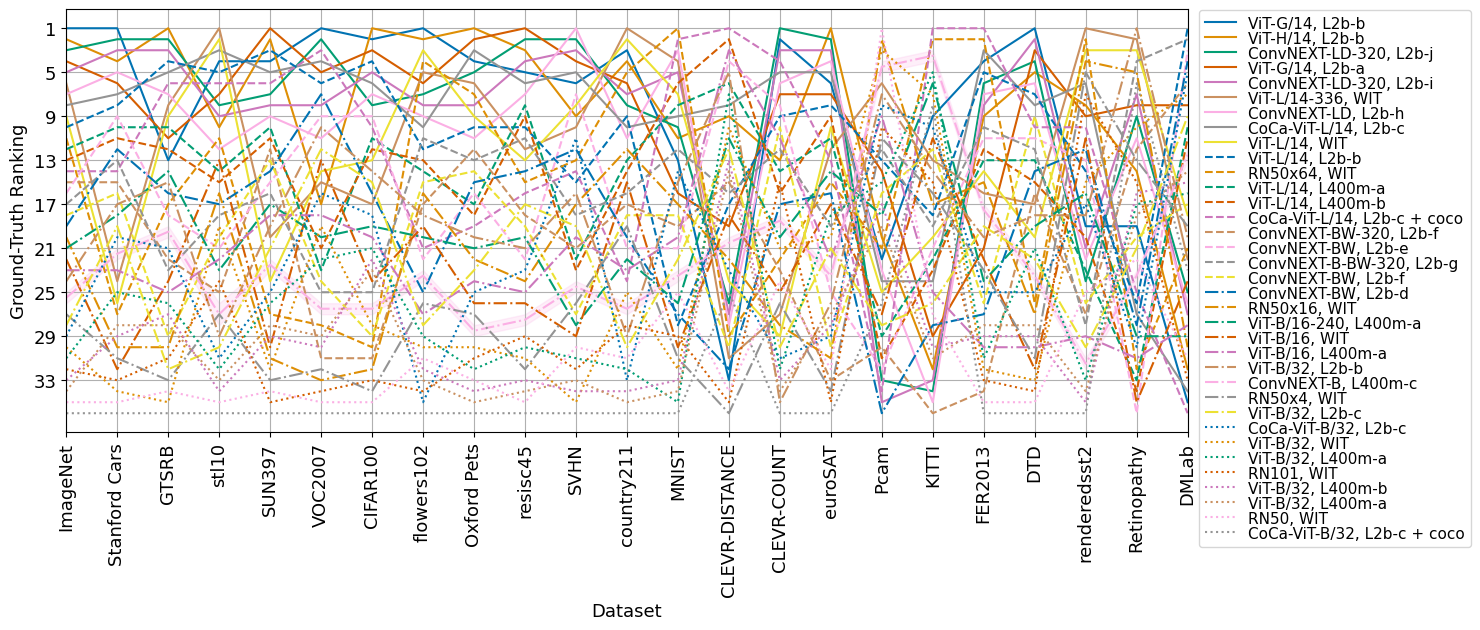

In [5]:
fig0, ax0 = plt.subplots(figsize=(15, 6.5))


new_names = df.model_fullname.unique()
original_names = [name_mapping[name] for name in new_names]

print(original_names)

legend=[]
tmp=pd.concat(dataset_rankings.values())
model_names_=tmp.model_fullname.unique()
for i, m in enumerate(model_names_):
    tmptmp=tmp.loc[tmp.model_fullname==m].sort_values('dataset_order')
    tmptmp = tmptmp.reset_index().drop_duplicates().set_index('index')
    sns.lineplot(x=tmptmp['dataset'], y=tmptmp['rank']+1, ax=ax0, linestyle=linestyle[i//9], label=name_mapping[m])
    


gt_ranking=tmp
ax0.invert_yaxis()
ax0.set_xticklabels([name_order[d] for d in datasets], rotation=90)

ax0.legend(loc=[1.01,-0.27], facecolor='white',ncol=1, labelspacing=0, fontsize =11)
ax0.set_xlabel('Dataset')
ax0.set_xlim([0,22])
ax0.set_ylabel('Ground-Truth Ranking')
ax0.set_yticks([i+1 for i in range(0,35, 4)])
#ax0.set_ylim([15,0])
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("RankingGT.png", dpi=300)
plt.show()

In [6]:
features = ['text-f1', 'IN-score']
#features = ['superclass_metric', 'inter_close', 'IN-score']
#target = PRED_TARGET
df_dataset=df

model_gpt = ModelGPTPredictor(df, features=features)
pred, _ = model_gpt.loo_dataset_rank()
pred = pred.T

dataset_rankings={}
for dataset in datasets:
    df_dataset = df.loc[df.dataset==dataset][["model_fullname", "pretrained", "dataset", "dataset_order"]]

    for m_fn in df_dataset.model_fullname:
        df_dataset.loc[df_dataset.model_fullname==m_fn, 'lin_model']= pred[dataset][m_fn]
    
    dataset_rankings[dataset] = df_dataset.sort_values("lin_model", ascending=False).reset_index()
    dataset_rankings[dataset]['rank']=dataset_rankings[dataset].index


['ViT-B/32, L2b-c', 'ConvNEXT-BW, L2b-f', 'RN101, WIT', 'RN50, WIT', 'RN50x16, WIT', 'RN50x64, WIT', 'ViT-B/16, WIT', 'ViT-B/32, WIT', 'ViT-L/14-336, WIT', 'ViT-L/14, WIT', 'CoCa-ViT-L/14, L2b-c + coco', 'CoCa-ViT-B/32, L2b-c + coco', 'ConvNEXT-B, L400m-c', 'ViT-G/14, L2b-b', 'CoCa-ViT-L/14, L2b-c', 'CoCa-ViT-B/32, L2b-c', 'ConvNEXT-BW-320, L2b-f', 'ConvNEXT-B-BW-320, L2b-g', 'RN50x4, WIT', 'ViT-L/14, L400m-a', 'ConvNEXT-BW, L2b-e', 'ConvNEXT-BW, L2b-d', 'ConvNEXT-LD, L2b-h', 'ConvNEXT-LD-320, L2b-i', 'ConvNEXT-LD-320, L2b-j', 'ViT-G/14, L2b-a', 'ViT-L/14, L2b-b', 'ViT-H/14, L2b-b', 'ViT-B/32, L400m-b', 'ViT-L/14, L400m-b', 'ViT-B/16-240, L400m-a', 'ViT-B/16, L400m-a', 'ViT-B/32, L400m-a', 'ViT-B/32, L400m-a', 'ViT-B/32, L2b-b']


/tmp/orrzohar/ipykernel_1310020/4108281121.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([name_order[d] for d in datasets], rotation=90)


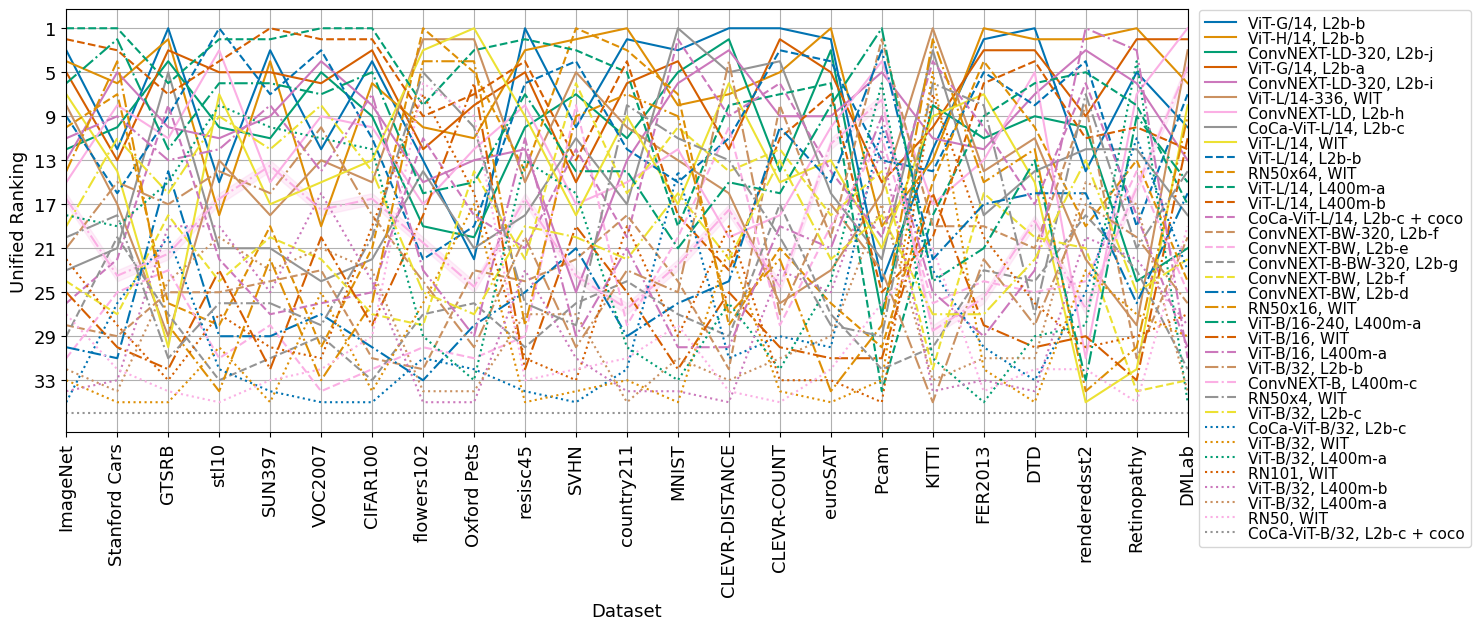

In [7]:
fig0, ax0 = plt.subplots(figsize=(15, 6.5))


new_names = df.model_fullname.unique()
original_names = [name_mapping[name] for name in new_names]

print(original_names)

legend=[]
tmp=pd.concat(dataset_rankings.values())

for i, m in enumerate(model_names_):
    tmptmp=tmp.loc[tmp.model_fullname==m].sort_values('dataset_order')
    tmptmp = tmptmp.reset_index().drop_duplicates().set_index('index')
    sns.lineplot(x=tmptmp['dataset'], y=tmptmp['rank']+1, ax=ax0, linestyle=linestyle[i//9], label=name_mapping[m])
    


gt_ranking=tmp
ax0.invert_yaxis()
ax0.set_xticklabels([name_order[d] for d in datasets], rotation=90)

ax0.legend(loc=[1.01,-0.27], facecolor='white',ncol=1, labelspacing=0, fontsize =11)
ax0.set_xlabel('Dataset')
ax0.set_xlim([0,22])
ax0.set_ylabel('Unified Ranking')
ax0.set_yticks([i+1 for i in range(0,35, 4)])
#ax0.set_ylim([15,0])
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("RankingU.png", dpi=300)
plt.show()


In [8]:
from LOVM.lovm import LOVM

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#FF5733', '#FFC300', '#DAF7A6', '#AED6F1', '#F1948A', '#AF7AC5', '#F8C471', '#D7DBDD', '#A2D9CE', '#5499C7', '#BB8FCE', '#F7DC6F', '#00CED1', '#FF6347', '#00FFFF']

target = 'acc1'
df_dataset=df

lovm = LOVM()
pred = lovm.get_imagenet_dataset_rank()
pred = pred.T

dataset_rankings={}
for dataset in datasets:
    df_dataset = df.loc[df.dataset==dataset][["model_fullname", "pretrained", "dataset", "dataset_order"]]

    for m_fn in df_dataset.model_fullname:
        df_dataset.loc[df_dataset.model_fullname==m_fn, 'lin_model']= pred[dataset][m_fn]
    
    dataset_rankings[dataset] = df_dataset.sort_values("lin_model", ascending=False).reset_index()
    dataset_rankings[dataset]['rank']=dataset_rankings[dataset].index


['ViT-B/32, L2b-c', 'ConvNEXT-BW, L2b-f', 'RN101, WIT', 'RN50, WIT', 'RN50x16, WIT', 'RN50x64, WIT', 'ViT-B/16, WIT', 'ViT-B/32, WIT', 'ViT-L/14-336, WIT', 'ViT-L/14, WIT', 'CoCa-ViT-L/14, L2b-c + coco', 'CoCa-ViT-B/32, L2b-c + coco', 'ConvNEXT-B, L400m-c', 'ViT-G/14, L2b-b', 'CoCa-ViT-L/14, L2b-c', 'CoCa-ViT-B/32, L2b-c', 'ConvNEXT-BW-320, L2b-f', 'ConvNEXT-B-BW-320, L2b-g', 'RN50x4, WIT', 'ViT-L/14, L400m-a', 'ConvNEXT-BW, L2b-e', 'ConvNEXT-BW, L2b-d', 'ConvNEXT-LD, L2b-h', 'ConvNEXT-LD-320, L2b-i', 'ConvNEXT-LD-320, L2b-j', 'ViT-G/14, L2b-a', 'ViT-L/14, L2b-b', 'ViT-H/14, L2b-b', 'ViT-B/32, L400m-b', 'ViT-L/14, L400m-b', 'ViT-B/16-240, L400m-a', 'ViT-B/16, L400m-a', 'ViT-B/32, L400m-a', 'ViT-B/32, L400m-a', 'ViT-B/32, L2b-b']


/tmp/orrzohar/ipykernel_1310020/175364398.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([name_order[d] for d in datasets], rotation=90)


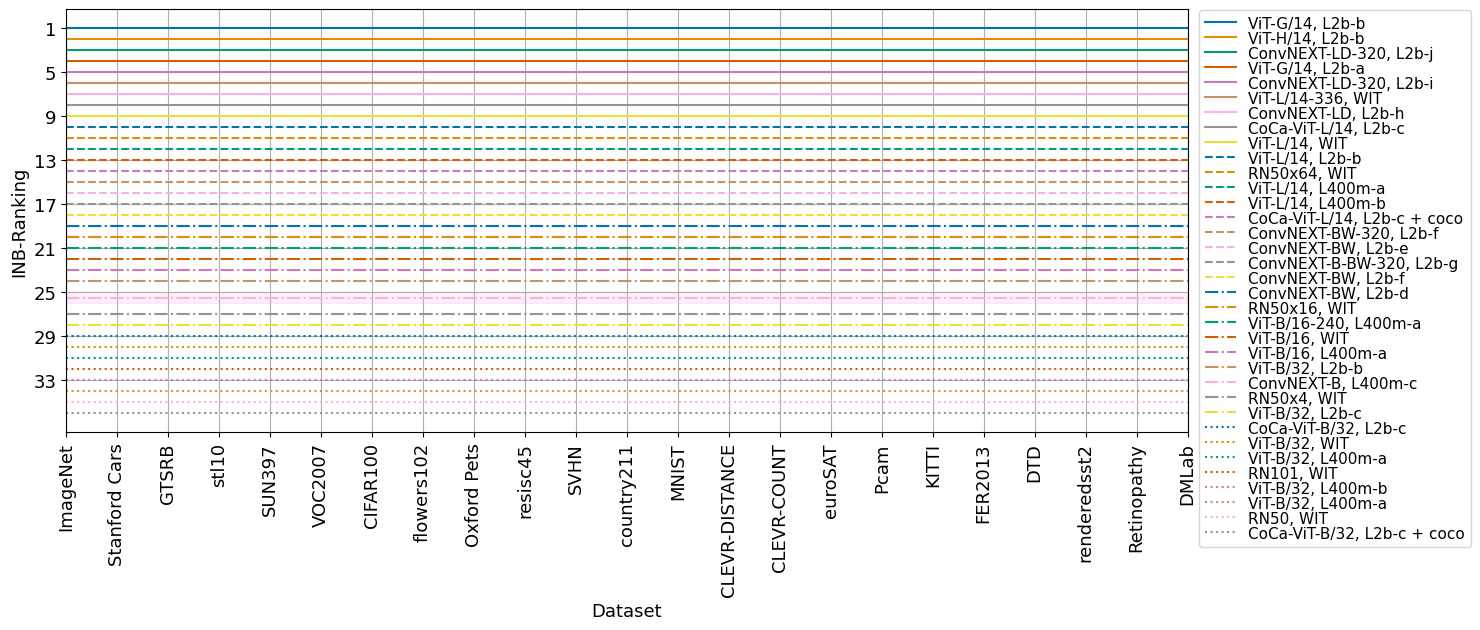

In [9]:
fig0, ax0 = plt.subplots(figsize=(15, 6.5))


new_names = df.model_fullname.unique()
original_names = [name_mapping[name] for name in new_names]

print(original_names)

legend=[]
tmp=pd.concat(dataset_rankings.values())
for i, m in enumerate(model_names_):
    tmptmp=tmp.loc[tmp.model_fullname==m].sort_values('dataset_order')
    tmptmp = tmptmp.reset_index().drop_duplicates().set_index('index')
    sns.lineplot(x=tmptmp['dataset'], y=tmptmp['rank']+1, ax=ax0, linestyle=linestyle[i//9], label=name_mapping[m])
    


gt_ranking=tmp
ax0.invert_yaxis()
ax0.set_xticklabels([name_order[d] for d in datasets], rotation=90)

ax0.legend(loc=[1.01,-0.27], facecolor='white',ncol=1, labelspacing=0, fontsize =11)
ax0.set_xlabel('Dataset')
ax0.set_xlim([0,22])
ax0.set_ylabel('INB-Ranking')
ax0.set_yticks([i+1 for i in range(0,35, 4)])
#ax0.set_ylim([15,0])
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("RankingINB.png", dpi=300)
plt.show()


In [11]:
from modelGPT.utils import eval_on_dataset
sigmas = [0.00, 0.075, 0.1, 0.125, 0.2, 0.4]

for dataset in datasets:
    data ={}
    with open(f"modelGPT/encoded_captions_dataset/{dataset}.pkl", 'rb') as file:
        while True:
            try:
                loaded_object = pickle.load(file)
                data.update(loaded_object)
            except EOFError:
                break

    models = {}
    with open(f"modelGPT/models/{dataset}.pkl", 'rb') as file:
        while True:
            try:
                loaded_object = pickle.load(file)
                models.update(loaded_object)
            except EOFError:
                break
            
    for sigma in tqdm(sigmas, leave=False, position=0, desc=dataset):
        for m in models.keys():
            tmp=eval_on_dataset(data[m], models[m].cuda(), sigma)
            df.loc[(df.model_fullname==m[0]+" "+m[1])&(df.dataset==dataset), f'text-acc1-{sigma}']=tmp[1]

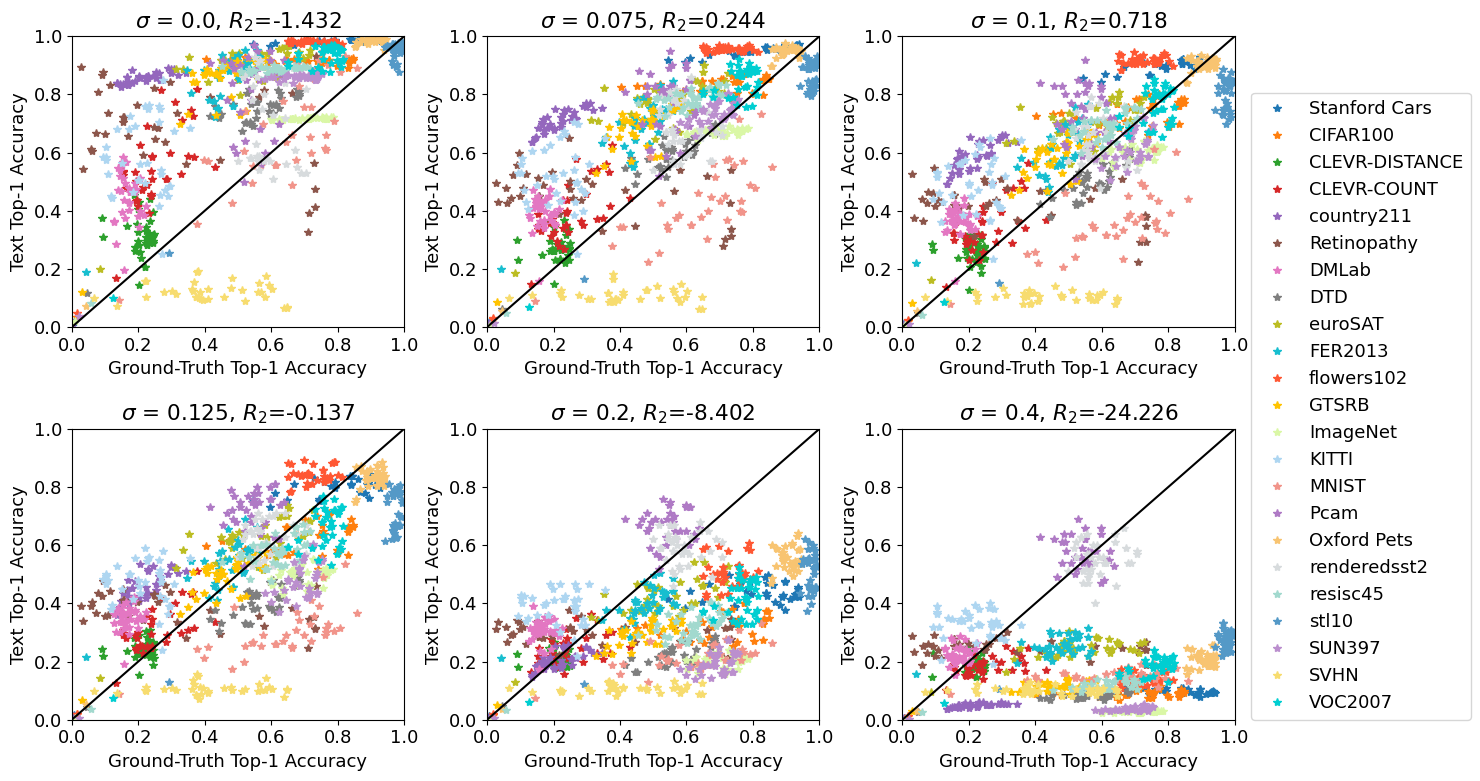

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
fig, ax = plt.subplots(2, 3,figsize=(15, 8))
colors  = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#FF5733', '#FFC300', '#DAF7A6', '#AED6F1', '#F1948A', '#AF7AC5', '#F8C471', '#D7DBDD', '#A2D9CE', '#5499C7', '#BB8FCE', '#F7DC6F', '#00CED1', '#FF6347', '#00FFFF']
y_true  = []
y_preds = []
legend  = []
sigmas = [0.00, 0.075, 0.1, 0.125, 0.2, 0.4]
for j, sigma in enumerate(sigmas):
    row, col = np.unravel_index(j, (2, 3))
    for i, dataset in enumerate(df.dataset.unique()):
        tmp = df.loc[df.dataset==dataset]
        ax[row, col].plot( tmp[PRED_TARGET],tmp[f'text-acc1-{sigma}'],'*', c=colors[i])
        score = round(pearsonr(tmp[PRED_TARGET], tmp[f'text-acc1-{sigma}']).statistic, 3)
        l1 = round(mean_absolute_error(tmp[PRED_TARGET], tmp[f'text-acc1-{sigma}']),3)
        r2 = round(r2_score(tmp[PRED_TARGET], tmp[f'text-acc1-{sigma}']),3)

        ax[row, col].set_title(f'$\sigma$ = {sigma}, $R_2$={r2}')
        ax[row, col].set_xlim([0.0,1.0])
        ax[row, col].set_ylim([0.0,1.0])
        
        ax[row, col].set_ylabel('Text Top-1 Accuracy')
        ax[row, col].set_xlabel('Ground-Truth Top-1 Accuracy')
        #y_true.extend(y)
        #y_preds.extend(y_pred)
        
ax[row, col].legend([name_order[f] for f in df.dataset.unique()], loc=(1.05,0.0))

for j, _ in enumerate(sigmas):
    row, col = np.unravel_index(j, (2, 3))
    ax[row, col].plot([0,1],[0,1], c='k')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig("TextAccurcayExperiment.png", dpi=300)

